# customed Fake Face classifier

In [1]:
import torch
import torch.nn as nn
import torchvision.models as models
import matplotlib.pyplot as plt
import numpy as np

In [2]:
# Using GPU
device = 'cuda' if torch.cuda.is_available() else 'cpu'
device

'cuda'

# Load Dataset

In [5]:
from google.colab import drive
drive.mount('/content/drive')

# You can add the shortcut for this diectory
%cd /content/drive/MyDrive/COMP4471_project/vgg-face-fakeFace-Classifier
!ls

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
/content/drive/MyDrive/COMP4471_project/vgg-face-fakeFace-Classifier
__pycache__  real_and_fake_face  vgg-face-classifier.ipynb  vgg_face.py  vgg_face_torch


In [6]:
import requests
import zipfile
from pathlib import Path

# Setup path to data folder
path = '/content/drive/MyDrive/COMP4471_project/vgg-face-fakeFace-Classifier/'
image_path = Path(path) / "real_and_fake_face"

if image_path.is_dir():
    print(f"{image_path} directory exists.")
else:
    print(f"Did not find {image_path} directory")

/content/drive/MyDrive/COMP4471_project/vgg-face-fakeFace-Classifier/real_and_fake_face directory exists.


# Load the dataset with the two classes

In [ ]:
# real_dir = image_path / 'training_real'
# fake_dir = image_path / 'training_fake'
# real_dir, fake_dir
# # print(real_dir.is_dir(), fake_dir.is_dir())

True True


In [ ]:
# from torchvision import datasets, transforms
# from torchvision.transforms import ToTensor
# from torch.utils.data import DataLoader

# data_transform = transforms.Compose([
#     transforms.Resize(size=(224, 224)),
#     transforms.ToTensor()
# ])

# real_data = datasets.ImageFolder(root=real_dir, transform=data_transform)
# fake_data = datasets.ImageFolder(root=fake_dir, transform=data_transform)

# Load the dataset has splitted into training and test

In [7]:
train_dir = image_path / "training"
test_dir = image_path / "test"

train_dir, test_dir

(PosixPath('/content/drive/MyDrive/COMP4471_project/vgg-face-fakeFace-Classifier/real_and_fake_face/training'),
 PosixPath('/content/drive/MyDrive/COMP4471_project/vgg-face-fakeFace-Classifier/real_and_fake_face/test'))

[PosixPath('/content/drive/MyDrive/COMP4471_project/vgg-face-fakeFace-Classifier/real_and_fake_face/training/real/real_00003.jpg'), PosixPath('/content/drive/MyDrive/COMP4471_project/vgg-face-fakeFace-Classifier/real_and_fake_face/training/real/real_00009.jpg'), PosixPath('/content/drive/MyDrive/COMP4471_project/vgg-face-fakeFace-Classifier/real_and_fake_face/training/real/real_00002.jpg'), PosixPath('/content/drive/MyDrive/COMP4471_project/vgg-face-fakeFace-Classifier/real_and_fake_face/training/real/real_00006.jpg'), PosixPath('/content/drive/MyDrive/COMP4471_project/vgg-face-fakeFace-Classifier/real_and_fake_face/training/real/real_00001.jpg'), PosixPath('/content/drive/MyDrive/COMP4471_project/vgg-face-fakeFace-Classifier/real_and_fake_face/training/real/real_00008.jpg'), PosixPath('/content/drive/MyDrive/COMP4471_project/vgg-face-fakeFace-Classifier/real_and_fake_face/training/real/real_00004.jpg'), PosixPath('/content/drive/MyDrive/COMP4471_project/vgg-face-fakeFace-Classifier/re

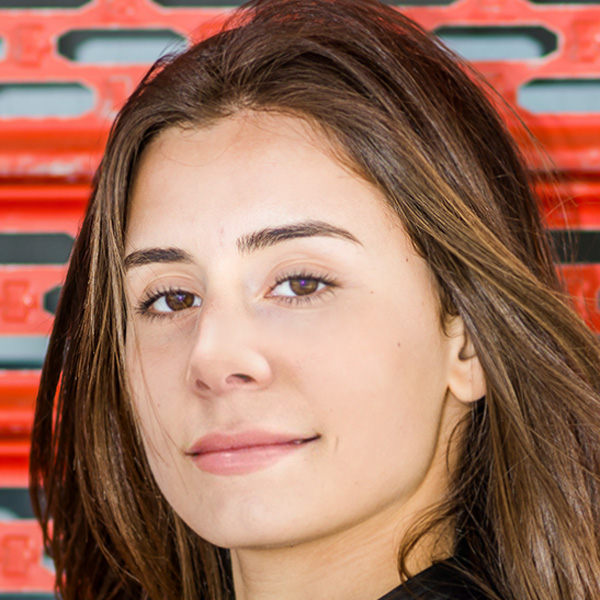

In [8]:
import random
from PIL import Image

random.seed(42)
image_path_list = list(image_path.glob("*/*/*.jpg"))
print(image_path_list)
random_image_path = random.choice(image_path_list)
image_class = random_image_path.parent.stem
img = Image.open(random_image_path)


print(f"Random image path: {random_image_path}")
print(f"Image class: {image_class}")
print(f"Image height: {img.height}")
print(f"Image width: {img.width}")
img

In [9]:
from torchvision import datasets, transforms
from torchvision.transforms import ToTensor
from torch.utils.data import DataLoader

data_transform = transforms.Compose([
    transforms.Resize(size=(224, 224)),
    transforms.ToTensor()
])

train_data = datasets.ImageFolder(root=train_dir, transform=data_transform, target_transform=None)
test_data = datasets.ImageFolder(root=test_dir, transform=data_transform)

In [10]:
class_names = train_data.classes
class_names

['fake', 'real']

In [11]:
if device == 'cuda':
  torch.set_default_tensor_type('torch.cuda.FloatTensor')
  print(device)
else:
  torch.set_default_tensor_type('torch.FloatTensor')

cuda


/usr/local/lib/python3.10/dist-packages/torch/__init__.py:614: UserWarning: torch.set_default_tensor_type() is deprecated as of PyTorch 2.1, please use torch.set_default_dtype() and torch.set_default_device() as alternatives. (Triggered internally at ../torch/csrc/tensor/python_tensor.cpp:451.)
  _C._set_default_tensor_type(t)


In [12]:
torch.set_default_tensor_type('torch.FloatTensor')

In [13]:
from torch.utils.data.dataloader import default_collate

batch_size = 64

train_dataloader = DataLoader(dataset=train_data,
                  batch_size=batch_size,
                  num_workers=1,
                  shuffle=True,
                  )

test_dataloader = DataLoader(dataset=test_data,
                batch_size=batch_size,
                num_workers=1,
                shuffle=False,
                )

In [ ]:
# torch.multiprocessing.set_start_method('spawn')

In [19]:
for b in train_dataloader:

  input = b[0]
  print(input.device)
  break

cpu


In [ ]:
device

'cpu'

# Customed model

In [14]:
input_shape = (3, 224,224)
droprate = 0.1
epsilon=0.001

In [15]:
class customedModel(nn.Module):
  def __init__(self, input_shape, padding=1, epsilon=1e-5, droprate=0.5):
    super(customedModel, self).__init__()

    self.features = nn.Sequential(
      nn.BatchNorm2d(input_shape[0]),
      nn.Conv2d(input_shape[0], 16, kernel_size=3, padding=padding),
      nn.ReLU(),
      nn.MaxPool2d(kernel_size=2),
      nn.BatchNorm2d(16, eps=epsilon),

      nn.Conv2d(16, 32, kernel_size=3, padding=padding),
      nn.ReLU(),
      nn.MaxPool2d(kernel_size=2),
      nn.BatchNorm2d(32, eps=epsilon),
      nn.Dropout2d(p=droprate),

      nn.Conv2d(32, 64, kernel_size=3, padding=padding),
      nn.ReLU(),
      nn.MaxPool2d(kernel_size=2),
      nn.BatchNorm2d(64, eps=epsilon),
      nn.Dropout2d(p=droprate),

      nn.Conv2d(64, 128, kernel_size=3, padding=padding),
      nn.ReLU(),
      nn.MaxPool2d(kernel_size=2),
      nn.BatchNorm2d(128, eps=epsilon),
      nn.Dropout2d(p=droprate),

      nn.Conv2d(128, 256, kernel_size=3, padding=padding),
      nn.ReLU(),
      nn.MaxPool2d(kernel_size=2),
      nn.BatchNorm2d(256, eps=epsilon),
      nn.Dropout2d(p=droprate),

      nn.Conv2d(256, 512, kernel_size=3, padding=padding),
      nn.ReLU(),
      nn.MaxPool2d(kernel_size=2),
      nn.BatchNorm2d(512, eps=epsilon),
      nn.Dropout2d(p=droprate),

      nn.AdaptiveAvgPool2d(1)
    )

    self.classifier = nn.Sequential(
        nn.Flatten(),
        nn.Linear(512, 1),
        nn.Sigmoid()
    )

  def forward(self, x):
      x = self.features(x)
      x = self.classifier(x)
      return x


In [16]:
def initialize_weights(model):
  if isinstance(model, (nn.Conv2d, nn.Linear)):
    nn.init.xavier_uniform_(model.weight)
    nn.init.zeros_(model.bias)

# Customed model

In [17]:
model = customedModel(input_shape, padding=1, epsilon=epsilon, droprate=droprate)
model.apply(initialize_weights)
model

customedModel(
  (features): Sequential(
    (0): BatchNorm2d(3, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (1): Conv2d(3, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (2): ReLU()
    (3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (4): BatchNorm2d(16, eps=0.001, momentum=0.1, affine=True, track_running_stats=True)
    (5): Conv2d(16, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (6): ReLU()
    (7): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (8): BatchNorm2d(32, eps=0.001, momentum=0.1, affine=True, track_running_stats=True)
    (9): Dropout2d(p=0.1, inplace=False)
    (10): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU()
    (12): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (13): BatchNorm2d(64, eps=0.001, momentum=0.1, affine=True, track_running_stats=True)
    (14): Dropout2d(p=0.1, inplace=

In [ ]:
from torchsummary import summary
summary(model, (3, 224, 224))

In [20]:
next(model.parameters()).is_cuda

False

# Plot helper funciton

In [21]:
def plot_loss(epochs, loss, val_loss):
    plt.plot(epochs, loss, 'bo', label='Training Loss')
    plt.plot(epochs, val_loss, 'orange', label = 'Validation Loss')
    plt.title('Training and Validation Loss')
    plt.legend()
    plt.show()

def plot_accuracy(epochs, acc, val_acc):
    plt.plot(epochs, acc, 'bo', label='Training accuracy')
    plt.plot(epochs, val_acc, 'orange', label = 'Validation accuracy')
    plt.title('Training and Validation Accuracy')
    plt.legend()
    plt.show()

# Set up optimizaer and Loss function

In [22]:
# Setup loss function and optimization algorithm
loss_fn = nn.BCEWithLogitsLoss()
optimizer = torch.optim.Adam(model.parameters(), 5e-4)

# Hyperparameters

In [23]:
epochs = 10

# Train/Fine-tune

In [25]:
from tqdm.auto import tqdm
torch.manual_seed(42)

In [26]:

def accuracy(y_true, y_pred):
    correct = torch.eq(y_true, y_pred).sum().item()
    acc = (correct / len(y_pred)) * 100

    return acc

In [27]:
train_losses, test_losses = [], []
train_accs, test_accs = [], []
i = 0

for epoch in tqdm(range(epochs)):
  print(f'Epoch: {epoch} -----')
  train_loss, train_acc = 0, 0

  model.train()
  for batch, (X, y) in enumerate(train_dataloader):
    y = y.view(-1, 1).float()
    y_pred = model(X)
    loss = loss_fn(y_pred, y)
    train_loss += loss.item()
    y_pred = (y_pred >= 0.5).float()
    train_acc += accuracy(y_true=y, y_pred=y_pred)

    optimizer.zero_grad()
    loss.backward()
    torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=1)
    optimizer.step()

    if batch % 200 == 0:
      print(f"Looked at {batch * len(X)}/{len(train_dataloader.dataset)} samples")

  train_loss /= len(train_dataloader)
  train_acc /= len(train_dataloader)
  train_losses.append(train_loss)
  train_accs.append(train_acc)
  print(f"Train loss: {train_loss:.5f} | Train accuracy: {train_acc:.2f}%\n")

  model.eval()
  with torch.inference_mode():
    test_loss, test_acc = 0.0, 0.0

    for X, y in test_dataloader:
      y = y.view(-1, 1).float()
      test_pred = model(X)
      test_loss += loss_fn(test_pred, y).item()
      test_pred = (test_pred >= 0.5).float()
      test_acc += accuracy(y_true=y, y_pred=test_pred)

    test_loss /= len(test_dataloader)
    test_acc /= len(test_dataloader)
    test_losses.append(test_loss)
    test_accs.append(test_acc)
    print(f"Test loss: {test_loss:.5f} | Test accuracy: {test_acc:.2f}%\n")

  0%|          | 0/10 [00:00<?, ?it/s]

Epoch: 0 -----
Looked at 0/1800 samples
Train loss: 0.73248 | Train accuracy: 51.51%

Test loss: 0.54736 | Test accuracy: 76.56%

Epoch: 1 -----
Looked at 0/1800 samples
Train loss: 0.72835 | Train accuracy: 51.62%

Test loss: 0.59122 | Test accuracy: 59.69%

Epoch: 2 -----
Looked at 0/1800 samples
Train loss: 0.71571 | Train accuracy: 53.99%

Test loss: 0.63350 | Test accuracy: 43.89%

Epoch: 3 -----
Looked at 0/1800 samples
Train loss: 0.70660 | Train accuracy: 55.44%

Test loss: 0.62806 | Test accuracy: 43.65%

Epoch: 4 -----
Looked at 0/1800 samples
Train loss: 0.70812 | Train accuracy: 50.81%

Test loss: 0.59520 | Test accuracy: 51.51%

Epoch: 5 -----
Looked at 0/1800 samples
Train loss: 0.69794 | Train accuracy: 56.20%

Test loss: 0.61890 | Test accuracy: 44.31%

Epoch: 6 -----
Looked at 0/1800 samples
Train loss: 0.68876 | Train accuracy: 55.39%

Test loss: 0.61542 | Test accuracy: 40.19%

Epoch: 7 -----
Looked at 0/1800 samples
Train loss: 0.68646 | Train accuracy: 55.33%

Test

In [29]:
model.eval()
with torch.inference_mode():
  test_loss, test_acc = 0.0, 0.0
  for X, y in test_dataloader:
    y = y.view(-1, 1).float()
    test_pred = model(X)
    # print(y[0], test_pred[0])
    test_loss += loss_fn(test_pred, y)
    test_pred = (test_pred >= 0.5).float()
    acc = accuracy(y_true=y, y_pred=test_pred)
    test_acc += acc
    # print(acc)

  test_loss /= len(test_dataloader)
  test_acc /= len(test_dataloader)
  print(f"Test loss: {test_loss:.5f} | Test accuracy: {test_acc :.2f}%\n")

Test loss: 0.57044 | Test accuracy: 59.30%



# Loss and accuarcy

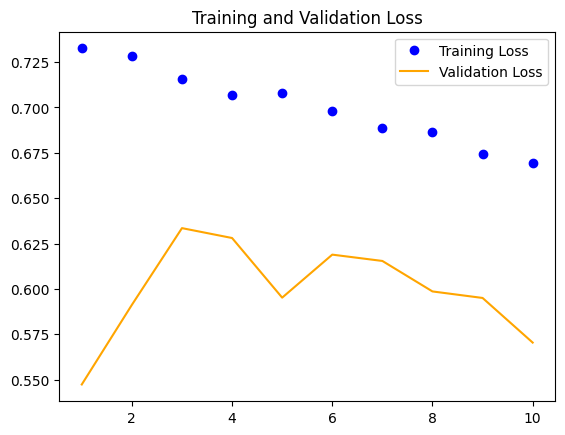

In [30]:
plot_loss(range(1, len(train_losses) + 1), train_losses, test_losses)

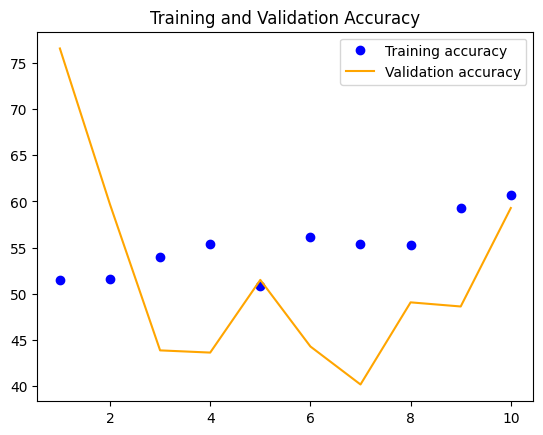

In [32]:
plot_accuracy(range(1, len(train_losses) + 1), train_accs, test_accs)

# Save the model

In [33]:
from pathlib import Path

# Create models directory (if it doesn't already exist)
MODEL_PATH = Path("models")
MODEL_PATH.mkdir(parents=True, exist_ok=True)

# Create model save path
MODEL_NAME = "fake-image-model.pth"
MODEL_SAVE_PATH = MODEL_PATH / MODEL_NAME

# Save the model state dict
print(f"Saving model to: {MODEL_SAVE_PATH}")
torch.save(obj=model.state_dict(), f=MODEL_SAVE_PATH)

Saving model to: models/fake-image-model.pth


# *Visualization*


*   Train/test accuarcies vs Epoachs
*   Confusion Matrix
*   F1 score
*   AUC
*   ROC



